parallel edges set() ; loops []
len(all_edges)_final 92 is? equal to start 92




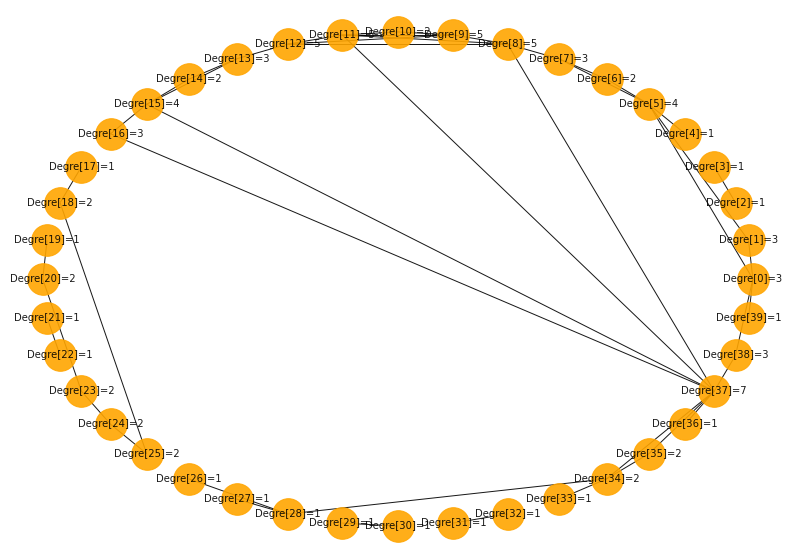

In [1]:
#right definitionsss!!! Net is built!

def pois_pos_degrees(N, D):
  import numpy as np
  np.random.seed(0)

  'Draw N degrees from a Poissonian sequence with lambda = D and length L'
  def remove_zeros(array):
    #print("array", array, "degarray", np.sum(array))
    its = 0
    while True:
      its += 1
      mask = np.where(array == 0)
      if not mask[0].size: 
        #print(f"Replacing non-0 degrees in {its} iterations")
        return array
      
      'the sum of the degrees must be even'
      psum = np.sum(array)
      #print("psum", psum)
      if not psum % 2: #psum is even return even cover
        while True:
          its += 1
          cover = np.random.poisson(lam = D, size = len(array[mask]))
          #print("even cover?", cover)
          if not np.sum(cover) % 2: break
      else:
        while True: #psum is odd return odd cover
          its += 1
          cover = np.random.poisson(lam = D, size = len(array[mask]))
          if np.sum(cover) % 2: break
      #print("cover final", cover)
      array[mask] = cover

  pos_degrees = np.random.poisson(lam = D, size = N)
  pos_degrees = remove_zeros(pos_degrees)
  #print(pos_degrees)
  return pos_degrees


def dic_nodes_degrees(degrees):
    np.random.seed(1)
    #print("degrees", degrees, sum(degrees))
    nodes = np.arange(N)
    dic_nodes = nodes.copy()
    np.random.shuffle(dic_nodes)
    dic_nodes = {k:v for k in dic_nodes for v in np.sort(degrees)[np.where(dic_nodes == k)]}
    sorted_nodes = np.array([x for x in dic_nodes.keys()])
    #print(f'nodes: {nodes}, sorted_nodes: {sorted_nodes}', "dic_nodes", dic_nodes, np.sort(degrees))
    return dic_nodes

def delete_node_from_both(avl_node, nodes, sorted_nodes, b_bool):
    nodes = np.delete(nodes, np.where(nodes == avl_node))
    sorted_nodes = np.delete(sorted_nodes, np.where(sorted_nodes == avl_node))
    #print(f'len(nodes): {len(nodes)}',)
    if len(nodes) == 1: 
        #print(f'\nEnd By len(nodes):{len(nodes)},{len(sorted_nodes)}')
        b_bool = True
    return nodes, sorted_nodes, b_bool

def add_edge(snode, i, b_bool, edges, sorted_nodes, nodes, dic_nodes):
    D = len(nodes)
    snode_idx = np.where(nodes == snode)[0]
    avl_node = nodes[(snode_idx+i)%D] #nearest available node
    ##print(f'Inside i={i} with D = {D} add_edge: nodes: {nodes}, snode_idx[{snode}]:{snode_idx},' )   
    ##print(f"Before edge.add: selected node: {avl_node}, deg[{avl_node}]: {dic_nodes[int(avl_node)]}")
    edges.add((int(snode),int(avl_node)))
    dic_nodes[int(avl_node)] -= 1
    ##print(f'after edge.add: edges, dic_nodes[{avl_node}]', edges, dic_nodes[int(avl_node)])
    if dic_nodes[int(avl_node)]==1:
        nodes, sorted_nodes, b_bool = delete_node_from_both(avl_node,  nodes, sorted_nodes, b_bool)
        ##print(f'Deleted for low degree {avl_node}: nodes, sorted_nodes', nodes, sorted_nodes)

def edges_nearest_node(dc_dic_nodes):
    from copy import deepcopy
    dc_dic_nodes = deepcopy(dic_nodes)
    sorted_nodes = np.array([x for x in dc_dic_nodes.keys()])
    nodes = np.arange(len(sorted_nodes))
    ##print(f'nodes: {nodes}',f'sorted_nodes: {sorted_nodes}',)
    ##print(f'id(nodes): {id(nodes)}',f"id(dc_dic_nodes.keys)", id(dic_nodes.keys()), np.array(dic_nodes.keys()))
    edges = set()
    b_bool = False #breakingbool
    for snode in sorted_nodes:
        ##print(f'\nRecap nodes: nodes: {nodes}, sorted_nodes & degree', sorted_nodes, [dc_dic_nodes[k] for k in sorted_nodes])
        ##print(f'Choosen snode: {snode} with degree: {dc_dic_nodes[snode]}')
        snode_idx = np.where(nodes == snode)[0]
        for i in np.arange(1, dc_dic_nodes[snode]//2+1):
            no_avl_nodes = [a for (a,b) in edges if b == snode]
            ##print(f'check already takes edges & avl_nodes: {edges}, {no_avl_nodes}', )
            #if nodes[(snode_idx+i)%D] not in no_avl_nodes:
            add_edge(snode, i, b_bool, edges = edges, sorted_nodes = sorted_nodes, \
                nodes = nodes, dic_nodes = dc_dic_nodes)
            if b_bool: 
                ##print(f'i bbool break: ',)
                break
            add_edge(snode, -i, b_bool, edges = edges, sorted_nodes = sorted_nodes, \
                nodes = nodes, dic_nodes = dc_dic_nodes)
            if b_bool: 
                ##print(f'-i bbool break: ',)
                break

        if dc_dic_nodes[snode]%2: #and nodes[(snode_idx+1)%D] not in [b for (a,b) in edges if a == snode]:
            ##print("Odd last attachment")
            add_edge(snode = snode, i = 1, b_bool = b_bool, edges = edges, sorted_nodes = sorted_nodes, \
                nodes = nodes, dic_nodes = dc_dic_nodes)
            if b_bool: 
                ##print(f'Odd last bbool break: ',)
                break
        nodes, sorted_nodes, b_bool = delete_node_from_both(snode, nodes = nodes, sorted_nodes = sorted_nodes, b_bool = b_bool)
        ##print(f'End of 1 cycle deleted snode: {snode}')
        
        if b_bool: 
            ##print(f'End of all',)
            break
        ##print('After all the rewiring, left nodes', nodes, "sorted_nodes", sorted_nodes, "edges", edges)
    return edges

def NN_pois_net(N, D, dic_nodes, ext_D, folder = "bleah", p = 0, conn_flag = False):
    from definitions import check_loops_parallel_edges, infos_sorted_nodes, \
        long_range_edge_add, connect_net, N_D_std_D

    edges = edges_nearest_node(dic_nodes)
    G = nx.Graph()
    G.add_nodes_from(np.arange(N))
    G.add_edges_from(edges)

    check_loops_parallel_edges(G)
    infos_sorted_nodes(G, num_sorted_nodes=False)

    long_range_edge_add(G, p = p)
    connect_net(G, conn_flag = conn_flag)

    ##print(f"There are {len([j for i,j in G.degree() if j == 0])} 0 degree node as")
    _,D,_ = N_D_std_D(G)
    ##print(f"End of wiring with average degree {D} vs {ext_D}")
    ##print(f'G.is_connected(): {nx.is_connected(G)}',)
    
    return G

import networkx as nx
import matplotlib.pylab as plt
import numpy as np

N, D = 2, 40
degrees = pois_pos_degrees(N, D)
#print('N',N)
dic_nodes = dic_nodes_degrees(degrees)
G = NN_pois_net(N,D,dic_nodes,1)
fig, ax = plt.subplots(figsize = (14,10))
labels = {k:f"Degre[{k}]={v}" for k,v in dic_nodes.items()}

#print(f'labels: {labels}',)


nx.draw_circular(G, ax = ax, with_labels = True, labels = labels, width = 1, node_size = 1e3, alpha = 0.9, node_color = "orange", font_size = 10)
plt.show()

##print(f'dic_nodes: {dic_nodes}',)



pairs: {0: {0: 0, 1: 1, 2: 1}, 1: {1: 0, 0: 1, 2: 1}, 2: {2: 0, 0: 1, 1: 1}}
mean: 0    0.666667
1    0.666667
2    0.666667
dtype: float64
standdev: 0.4714045207910317


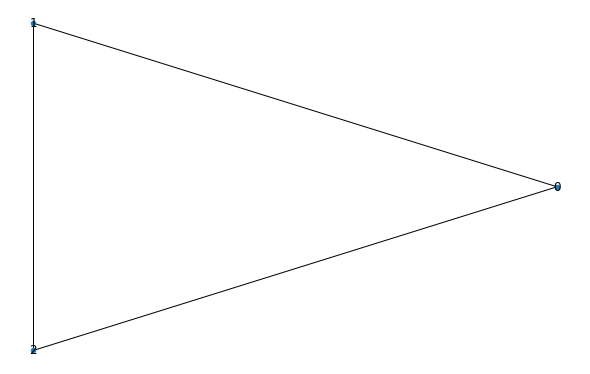

,0,1,2
0,0,1,1
1,1,0,1
2,1,1,0


In [34]:
import networkx as nx
import pandas as pd

G = nx.complete_graph(3)

import numpy as np

pairs = dict(nx.all_pairs_shortest_path_length(G))
df = pd.DataFrame(pairs)
mean = np.mean(df)
standdev = np.std(df, ddof = 0)
print(f'pairs: {pairs}',)

print(f'mean: {mean}',)
print(f'standdev: {standdev.tolist()[0]}',)

import matplotlib.pylab as plt

plt.figure(figsize = (8,5))
nx.draw_circular(G, with_labels = True, width = 1, node_size = 20)
plt.show()

df


In [22]:
import numpy as np
def rhu(n, decimals=0, integer = False): #round_half_up
    import math
    multiplier = 10 ** decimals
    res = math.floor(n*multiplier + 0.5) / multiplier
    if integer: return int(res)
    return res



R0_ls = sorted([x+1*j for x in [0.2,0.8] for j in np.arange(4)][1:-1])
R0_ls = [0.6,0.8,1.2,1.8,2.2,2.8,3.2]
mu = [rhu(0.5/x,3) for x in R0_ls]
print(f'mu: {mu}',f'R0_ls: {R0_ls}',
)


mu: [0.833, 0.625, 0.417, 0.278, 0.227, 0.179, 0.156] R0_ls: [0.6, 0.8, 1.2, 1.8, 2.2, 2.8, 3.2]


In [3]:
1/1.3

0.7692307692307692

In [4]:
(10 - 0.77)/2.3

4.01304347826087

In [1]:
def rhu(n, decimals=0, integer = False): #round_half_up
    import math
    multiplier = 10 ** decimals
    res = math.floor(n*multiplier + 0.5) / multiplier
    if integer: return int(res)
    return res

rhu(1.99)

2.0